# Clustering

## Abstract

This notebook will explore the actual process of clustering the data.  After reading in the data, there is one last bit of data preprocessing to conduct: dummying out categorical variables.  Once dummied, the data will be scaled so that distance based algorithms are comparing on a similar numerical scale.  The clustering will be evaluated numerically, and then the labels will be outputted to a csv so that further analysis can happen in the next notebook.

### Imports

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

### CSV Read-in

In [2]:
df = pd.read_csv("../data/musicdata_cleaned.csv")
df.head()

,artist_id,artist,album_id,album_names,track_id,track_number,track_title,track_duration,track_disc_number,danceability,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,is_live,is_instrumental,key_tone
0,1L0y9srZMyh9XUnYGv37IP,'Til Tuesday,67OxSfZotEq8cCa5SCeX5r,Everything's Different Now,5n9QFM4EiMeLGO0Mbwaqov,1.0,Everything's Different Now,236733.0,1.0,0.672,...,0.0393,0.0693,0.000033,0.1080,0.730,123.777,4.0,0,0,A#
1,1L0y9srZMyh9XUnYGv37IP,'Til Tuesday,67OxSfZotEq8cCa5SCeX5r,Everything's Different Now,0BKslA1XqG8HBUKBl4d7EN,2.0,Rip In Heaven,211200.0,1.0,0.612,...,0.0351,0.4280,0.000000,0.3470,0.815,131.809,4.0,0,0,E
2,1L0y9srZMyh9XUnYGv37IP,'Til Tuesday,67OxSfZotEq8cCa5SCeX5r,Everything's Different Now,5G7NBdQLHc7GkehNmLG3yJ,3.0,Why Must I,221000.0,1.0,0.586,...,0.0268,0.2290,0.000035,0.3230,0.838,96.486,4.0,0,0,C#
3,1L0y9srZMyh9XUnYGv37IP,'Til Tuesday,67OxSfZotEq8cCa5SCeX5r,Everything's Different Now,0J6nZDgEuwXtECq8Pukn1n,4.0,J For Jules,265493.0,1.0,0.475,...,0.0308,0.4620,0.000001,0.1190,0.262,151.651,4.0,0,0,A#
4,1L0y9srZMyh9XUnYGv37IP,'Til Tuesday,67OxSfZotEq8cCa5SCeX5r,Everything's Different Now,3Lm7hSTabr01oav0WdSsuD,5.0,(Believed You Were) Lucky,216973.0,1.0,0.612,...,0.0321,0.4480,0.000002,0.0727,0.495,124.315,4.0,0,0,F


## Feature Selection

### Dummying

In [3]:
df = pd.get_dummies(df, columns=["key_tone","time_signature"],drop_first=True)

In [4]:
df.columns

Index(['artist_id', 'artist', 'album_id', 'album_names', 'track_id',
       'track_number', 'track_title', 'track_duration', 'track_disc_number',
       'danceability', 'energy', 'key', 'is_major', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'is_live', 'is_instrumental', 'key_tone_A#', 'key_tone_B', 'key_tone_C',
       'key_tone_C#', 'key_tone_D', 'key_tone_D#', 'key_tone_E', 'key_tone_F',
       'key_tone_F#', 'key_tone_G', 'key_tone_G#', 'time_signature_1.0',
       'time_signature_3.0', 'time_signature_4.0', 'time_signature_5.0'],
      dtype='object')

In [5]:
df.drop(columns=["key","liveness","instrumentalness"], inplace=True)

In [6]:
features = ["track_duration", "danceability", "energy","is_major",
        "speechiness","acousticness","valence","tempo","is_live","is_instrumental",
       'key_tone_A#', 'key_tone_B', 'key_tone_C',
       'key_tone_C#', 'key_tone_D', 'key_tone_D#', 'key_tone_E', 'key_tone_F',
       'key_tone_F#', 'key_tone_G', 'key_tone_G#', 'time_signature_1.0',
       'time_signature_3.0', 'time_signature_4.0', 'time_signature_5.0']

In [7]:
X = df[features]

### Scaling

Scaling will be done before clustering so that a connectivity matrix can be generated ahead of time.

In [8]:
ss = StandardScaler()
X_sc = ss.fit_transform(X)

## Clustering

### Connectivity Matrix

In [9]:
connectivity = kneighbors_graph(X_sc,50,n_jobs=-1)

### Gridsearch

Before Gridsearching for a suitable number of clusters to cut at, I should determine a metric to evaluate on.  The two metrics for how good things got clustered that are commonly used are inertia and silhouette.  The former describes how closely related each element of a cluster is to other elements of that cluster, which is to say given any song of cluster $n$, another song of cluster $n$ should sound pretty similar, however some song from cluster $m$ could still sound similar.  Silhouette score tries to create more separation from each cluster, such that any song in cluster $n$ will not sound that much like any song from cluster $m$, but might not be as strongly connected to another song in cluster $n$.

#### Initial Clustering

Really want to try getting an estimate for number of clusters to look at, or rather, since this is an agglomerative model, really I am seeking where to 'slice' or stop the agglomeration.  Initially I will just start with something I feel is probably far too large

In [13]:
agc = AgglomerativeClustering(n_clusters=5000 ,connectivity=connectivity, linkage="ward")

In [14]:
agc.fit(X_sc)

C:\Anaconda3\envs\dsi\lib\site-packages\sklearn\cluster\hierarchical.py:193: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=<98337x98337 sparse matrix of type '<class 'numpy.float64'>'
	with 4916850 stored elements in Compressed Sparse Row format>,
            linkage='ward', memory=None, n_clusters=5000,
            pooling_func=<function mean at 0x00000238A526D268>)

In [18]:
df["label"] = agc.labels_

In [30]:
sum((df.label.value_counts() == 1).astype(int))

61

This means there are still $61$ clusters that contain exactly one element in them, I feel like there is more refiniment to be done with that.

So what exactly does the distribution look like?

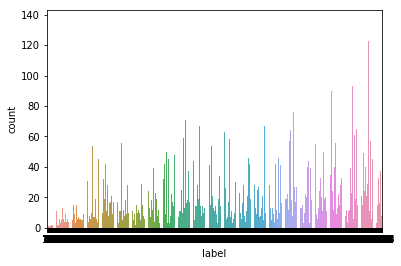

In [33]:
sns.countplot(df.label)

These bars almost seem grouped themelves, and there is about $23$ of them.

#### Next round of clustering

With a ballpark of $23$ I will try searching over clusters in that range, with a favoring for a higher number on the range.  As a reminder from the earlier discussion, silhouette score will be used here to try and pick the best cut.

In [ ]:
clusters_to_try = [i for i in range(15,45)]
fitted_clusterers = []
cluster_labels = []
silhouette_scores = []

for n_clusters in clusters_to_try:
    agc_i = AgglomerativeClustering(n_clusters=n_clusters ,connectivity=connectivity, linkage="ward")
    agc_i.fit(X_sc)
    cluster_labels.append(agc_i.labels_)
    fitted_clusterers.append(agc_i.labels_)
    silhouette_scores.append(silhouette_score(X_sc,
                                              agc_i.labels_,
                                              sample_size=30000, #Necessary to avoid a Memory Error!  Adjust this line if still too much.
                                              random_state=20191505))

### Evaluating

In [57]:
cluster_scores = pd.DataFrame({"n_clusters" : clusters_to_try, "silhouette_score" : silhouette_scores})
cluster_scores.head()

,n_clusters,silhouette_score
0,15,0.254349
1,16,0.256650
2,17,0.261489
3,18,0.251383
4,19,0.240935


In [58]:
silhouette_scores[2]

0.2614894562850657

In [60]:
df.drop(columns=["label","label_new"], inplace=True)

In [62]:
df["label"] = cluster_labels[2]

In [63]:
df.head()

,artist_id,artist,album_id,album_names,track_id,track_number,track_title,track_duration,track_disc_number,danceability,...,key_tone_E,key_tone_F,key_tone_F#,key_tone_G,key_tone_G#,time_signature_1.0,time_signature_3.0,time_signature_4.0,time_signature_5.0,label
0,1L0y9srZMyh9XUnYGv37IP,'Til Tuesday,67OxSfZotEq8cCa5SCeX5r,Everything's Different Now,5n9QFM4EiMeLGO0Mbwaqov,1.0,Everything's Different Now,236733.0,1.0,0.672,...,0,0,0,0,0,0,0,1,0,4
1,1L0y9srZMyh9XUnYGv37IP,'Til Tuesday,67OxSfZotEq8cCa5SCeX5r,Everything's Different Now,0BKslA1XqG8HBUKBl4d7EN,2.0,Rip In Heaven,211200.0,1.0,0.612,...,1,0,0,0,0,0,0,1,0,12
2,1L0y9srZMyh9XUnYGv37IP,'Til Tuesday,67OxSfZotEq8cCa5SCeX5r,Everything's Different Now,5G7NBdQLHc7GkehNmLG3yJ,3.0,Why Must I,221000.0,1.0,0.586,...,0,0,0,0,0,0,0,1,0,13
3,1L0y9srZMyh9XUnYGv37IP,'Til Tuesday,67OxSfZotEq8cCa5SCeX5r,Everything's Different Now,0J6nZDgEuwXtECq8Pukn1n,4.0,J For Jules,265493.0,1.0,0.475,...,0,0,0,0,0,0,0,1,0,4
4,1L0y9srZMyh9XUnYGv37IP,'Til Tuesday,67OxSfZotEq8cCa5SCeX5r,Everything's Different Now,3Lm7hSTabr01oav0WdSsuD,5.0,(Believed You Were) Lucky,216973.0,1.0,0.612,...,0,1,0,0,0,0,0,1,0,10


## Output

In [64]:
df.to_csv("../data/labeled.csv", index=False)